# COGS 118B - Final Project

# Exploring Different Reinforcement Learning Algorithms for Stock Trading to Optimize Profitability

## Group members

- Ryan Chen
- Nicholas Gao
- Matthew Miyagishima

# Abstract 

Stock trading is full of unpredictability and volatility. Without substantial understanding and experience in trading stocks, it is difficult for a person to trade actively and profit off of stocks. However, mathematical models and intelligent software can do a much better job of learning patterns and capitalizing on them. We explore the performance of value-based and policy-based reinforcement learning algorithms on trading stock data by comparing profits earned by Monte Carlo Q-learning, Monte Carlo policy gradient, and Advantage Actor-Critic on AAPL, TSLA, META, NVDA, and GME stocks from 2014 to 2024.

# Background

The stock market is a highly dynamic environment influenced by various factors, making it challenging to develop reliable trading strategies. Traditional rule-based approaches are often too rigid and fail to adapt to changing market conditions. Recently, machine learning techniques, particularly **Reinforcement Learning (RL)**, have become a popular tool for financial applications due to their ability to learn optimal strategies through direct interaction with the environment.

In this project, we aim to build a **stock market trading agent** that leverages **Markov Decision Processes (MDPs)** as the underlying framework and applies **Q-Learning** and **Monte Carlo methods** to learn an optimal trading policy. The agent will use historical stock price data to simulate trading decisions and learn when to buy, sell, or hold a stock to maximize long-term profitability. We will focus on backtesting the agent’s strategy on historical data to assess its performance in a simulated environment.


# Problem Statement

The objective of this project is to design a stock market trading agent that interacts with historical stock data and learns to optimize its trading strategy using **Markov Decision Processes (MDPs)**. The problem can be modeled as an MDP with the following components:

- **State Space:** The state provides information on stock prices over the past `window_size` days.
- **Action Space:** The agent can choose one of three actions at each time step:
  - **Buy:** Purchase some quantity of the stock.
  - **Sell:** Sell some quantity of held stocks.
  - **Hold:** Take no action and maintain the current position.
- **Reward Function:** The reward function rewards the agent for making profitable actions on each stock:
  - **Buy:** +5 reward for a valid purchase (based on agent's balance), +2 if agent overestimates number of stocks it can purchase, -5 reward if agent does not have enough money to even purchase one stock
  - **Sell:** +5 for a sell that increases the agent's total portfolio value, -2 if agent loses porfolio value after selling, and -5 for an invalid sell action
  - **Hold:** No reward or penalty
  - **Bonus:** Percentage change in portfolio value * 10

We will train the agent using three reinforcement learning approaches:
1. **Monte Carlo Q-Learning** a model-free method that learns the optimal action at each state.
2. **Monte Carlo Policy Gradient (REINFORCE)** a policy-based on-policy method that simulates entire processes and updates the policy according to the final reward.
3. **A2C** an improvement on REINFORCE that introduces an actor-critic architecture where the actor learns the policy while the critic estimates the value function.

We will evaluate the performance of each agent by looking at the final portfoliio value at the end of the time period. At the same time, we will be comparing their performance against that of the S&P500 across the same period.

# Data

We will use historical stock price data from the following sources:

1. **Yahoo Finance API** ([https://finance.yahoo.com](https://finance.yahoo.com))
   - Provides daily and intraday stock data.
   - Variables: `Date`, `Close`, `Split`.

2. **S&P 500 Historical Data**
   - Used as a benchmark for evaluating the trading agent’s performance.

### Data Preprocessing:
The Yahoo Finance API is a very developed API and has full data over the time period we are considering for the 5 chosen stocks. Thus no data preprocessing is required before using it to train our agents.

# Proposed Solution

We propose three different solutions to the stock trading problem. Each of the solution algorithms will train an agent to interact with the environment through buying, selling, and holding on to stocks. These agents will be trained on data on AAPL, TSLA, META, NVDA, and GME stocks from 2014 to 2024 to optimize their profits.

**Monte Carlo Q-Learning**

The Monte Carlo Q-Learning algorithm is a value-based on-policy algorithm. In each episode, an action is selected using an epsilon-greedy selection at each state. The entire 10-year stock trading experience is simulated while the state, action, and reward are tracked. At the end of an episode, the tracked states, actions, and rewards are used to update the Q-table at each of those states to favor certain actions over others. The process continues until the agent learns the task well.

Below is the pseudo-code for this algorithm:
```
for each episode:
    initialize the environment
    observe the initial state s
    episode = []

    while episode is not done:
        choose action a using epsilon-greedy policy from Q(s, *)
        take action a, record reward r and next state s'
        store (s, a, r) in episode
        s = s'
    
    G = 0
    for each step (s, a, r) in episode, in reverse order:
        G = gamma * G + r
        if (s, a) is the first occurence in the episode:
            append G to returns(s, a)
            Q(s, a) = average(returns(s, a))
return Q
```

**Monte Carlo Policy Gradient**

The Monte Carlo Policy Gradient, or REINFORCE, algorithm is a policy-based on-policy training algorithm. It is similar to MC Q-Learning in that the agent simulates entire episodes of the task based on its policy before updating. However, this algorithm utilizes a neural network to represent its policy, and action selection is over a distribution rather than an epsilon-greedy selection.

Below is the pseudo-code for this algorithm:
```
for each episode:
    initialize the environment
    observe the initial state s
    episode = []

    while episode is not done:
        get distribution from a forward pass
        choose action a using distribution
        take action a, record reward r and next state s'
        store (s, a, r) in episode
        s = s'
    
    G = 0
    for each step (s, a, r) in episode, in reverse order:
        G = gamma * G + r
        theta = theta + alpha * G * gradient(log(policy))
```

**A2C**

The Advantage Actor-Critic algorithm is a policy-based on-policy training algorithm. It combines both policy gradient and value function estimation where the actor learns the policy while the critic learns to estimate the value of states. This algorithm achieves a more stable learning compared to REINFORCE due to reduced variance in the gradient estimates since it uses advantage for gradient calculations.

Below is the pseudo-code for this algorithm:
```
for each episode:
    initialize the environment
    observe the initial state s
    episode = []

    while not done:
        get action distribution from actor
        choose action a using distribution
        take action a, record reward r and next state s'

        estimate value v of current state
        get value of next state v'
        set td target = r + gamma * v'

        compute advantage A = td target - v

        calculate squared loss for critic and update the critic
        update the actor: theta = theta + alpha * gradient(log(policy) * A)

        s = s'
```

# Evaluation Metrics

The main evaluation metric that we will use will be how much the agent grows/shrinks their portfolio percentage-wise over the test period. We will do so by giving the agent a portfolio to start off with at the beginning of the test period and evaluate the portfolio's worth daily throughout testing to measure how well the agent is doing. We believe that this is a good evaluation metric as the main goal of the agent is to maximize gains through buying, holding, and selling stocks.

A mathematical representation of this metric would be

$G_T = \frac{V_T - V_0}{V_0}$

Where
- $G_T$ is the gain/loss on day T
- $V_T$ is the value of the portfolio on day T
- $V_0$ is the value of the portfolio i the beginning

# Results

In [1]:
%load_ext autoreload
%autoreload 2

### Monte Carlo Simulations

In [1]:
from training_env import StockTrainingEnv
from monte_carlo import monte_carlo_train, monte_carlo_eval

In [2]:
# Set Up Stock Trading Environment
monte_carlo_env = StockTrainingEnv(tickers=['AAPL', 'TSLA', 'META', 'NVDA', 'GME'])

[*********************100%***********************]  5 of 5 completed


In [3]:
# Train the Monte Carlo Agent
monte_carlo_q_table = monte_carlo_train(monte_carlo_env)

Monte Carlo Training: 100%|██████████| 1000/1000 [06:10<00:00,  2.70it/s]

Monte Carlo training complete


In [4]:
# Evaluating the Agent Performance
monte_carlo_evaluation = monte_carlo_eval(monte_carlo_env, monte_carlo_q_table)

Step: 50, Balance: 5590.704895168543, Total Value: 10258.79915252328, Shares: {'AAPL': np.int64(17), 'TSLA': np.int64(100), 'META': np.int64(35), 'NVDA': np.int64(0), 'GME': np.int64(60)}
Step: 70, Balance: 365.6623710989952, Total Value: 9452.968418598175, Shares: {'AAPL': np.int64(142), 'TSLA': np.int64(0), 'META': np.float64(115.0), 'NVDA': np.int64(63), 'GME': np.int64(0)}
Step: 90, Balance: 0.1751250922679901, Total Value: 10425.326354056597, Shares: {'AAPL': np.float64(173.0), 'TSLA': np.float64(92.0), 'META': np.float64(100.0), 'NVDA': np.float64(50.0), 'GME': np.float64(7.0)}
Step: 110, Balance: 1671.967294126749, Total Value: 11281.990630596876, Shares: {'AAPL': np.float64(322.0), 'TSLA': np.float64(50.0), 'META': np.float64(24.0), 'NVDA': np.float64(25.0), 'GME': np.float64(99.0)}
Step: 130, Balance: 6.6436851024627686, Total Value: 11068.100925683975, Shares: {'AAPL': np.float64(101.0), 'TSLA': np.float64(222.0), 'META': np.float64(84.0), 'NVDA': np.float64(48.0), 'GME': np.

In [5]:
# Calculate the percent of positive profits
profit_list = monte_carlo_env.profits
positive_profits = [profit for profit in profit_list if profit > 0]
percentage_positive_profits = (len(positive_profits) / len(profit_list)) * 100 if profit_list else 0
print(f"Percentage of positive profits: {percentage_positive_profits:.2f}%")

Percentage of positive profits: 56.54%


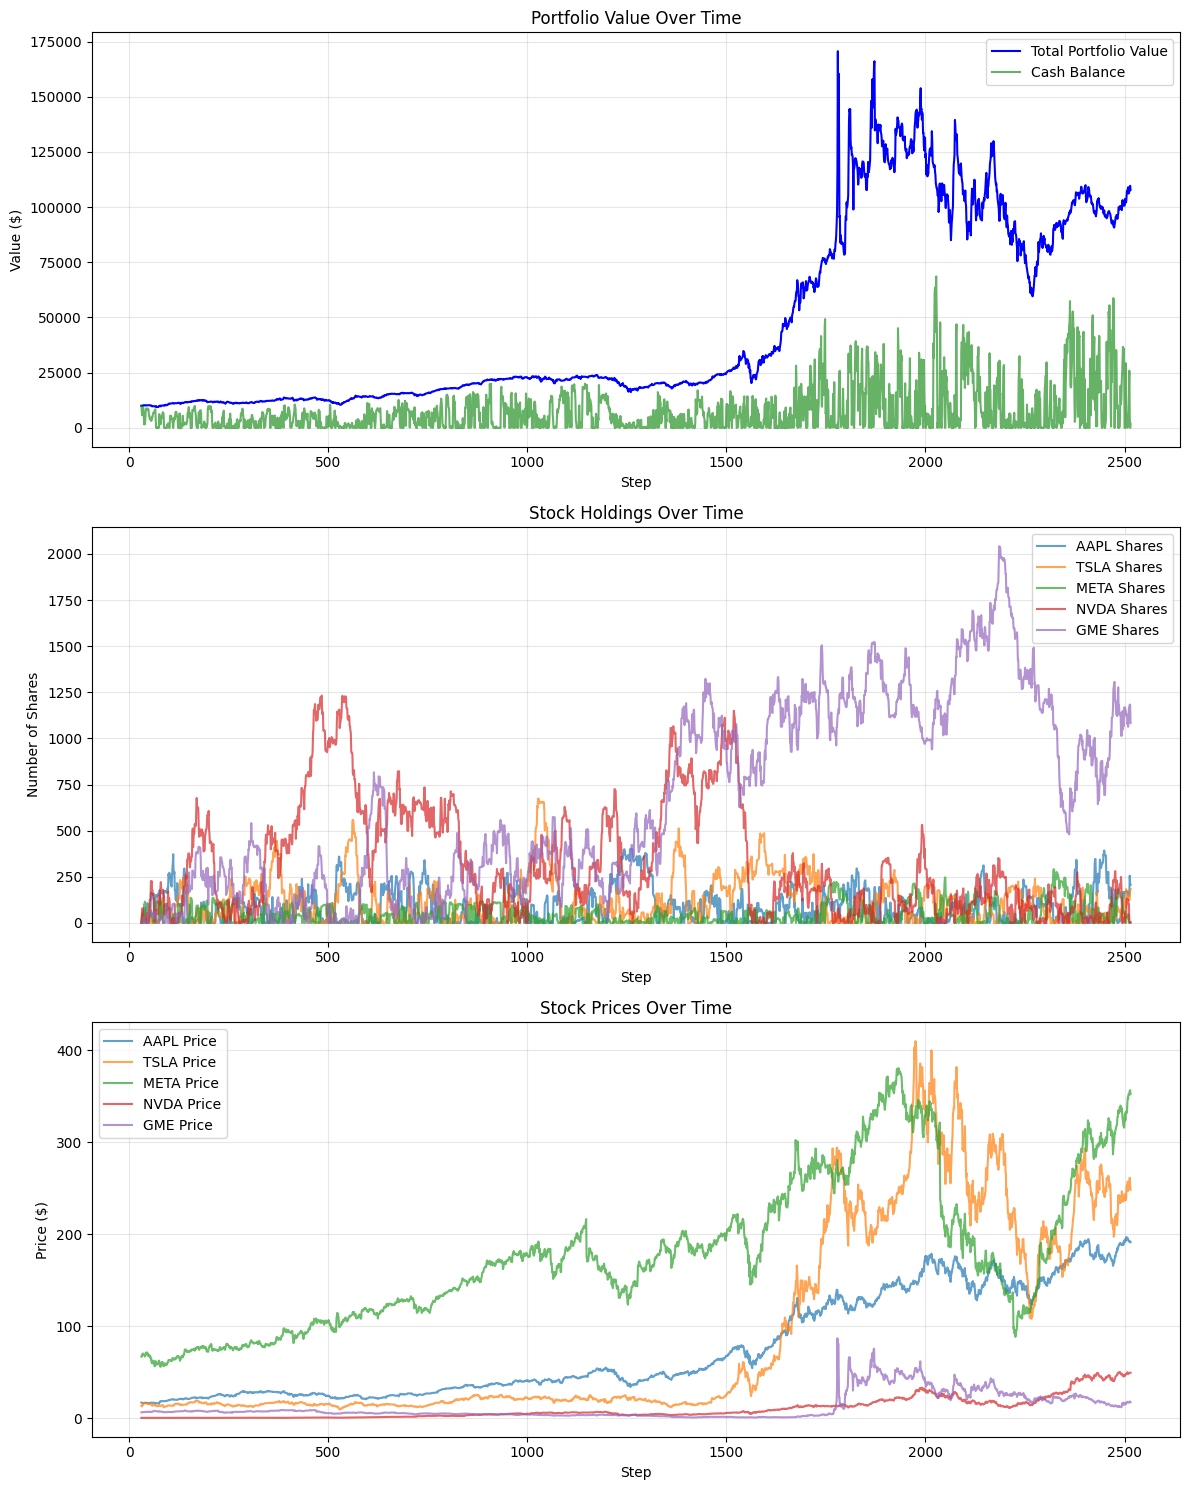

In [6]:
monte_carlo_env.plot_all_metrics()

### Policy Gradient

In [5]:
from policy_gradient import PolicyNetwork, PolicyGradientAgent, train_policy_gradient

In [ ]:
policy_gradient_env = StockTrainingEnv(tickers=['AAPL', 'TSLA', 'META', 'NVDA', 'GME'])

In [7]:
# # Define dimensions for the agent
state_dim = policy_gradient_env.observation_space.shape[1]
num_tickers = len(policy_gradient_env.tickers)
possible_trades = policy_gradient_env.possible_trades

In [8]:
# # Create agent
agent = PolicyGradientAgent(
    state_dim=state_dim,
    num_tickers=num_tickers,
    possible_trades=possible_trades
)

In [ ]:
# # Train agent
train_policy_gradient(policy_gradient_env, agent, episodes=1000, gamma=0.99, lr=0.001)

In [ ]:
profit_list = policy_gradient_env.profits
positive_profits = [profit for profit in profit_list if profit > 0]
percentage_positive_profits = (len(positive_profits) / len(profit_list)) * 100 if profit_list else 0
print(f"Percentage of positive profits: {percentage_positive_profits:.2f}%")

### A2C

In [7]:
from a2c_model import ActorCriticNetwork, A2CAgent, a2c_train, a2c_eval

Using device: cuda


In [8]:
a2c_env = StockTrainingEnv(tickers=['AAPL', 'TSLA', 'META', 'NVDA', 'GME'])

[*********************100%***********************]  5 of 5 completed


In [9]:
# Create Agent and train
a2c_agent = A2CAgent(a2c_env)
a2c_agent_train = a2c_train(a2c_env, a2c_agent)

A2C Training: 100%|██████████| 1000/1000 [34:31<00:00,  2.07s/it, reward=16.88, steps=200]


In [10]:
# Evaluate A2C agent
a2c_agent_eval = a2c_eval(a2c_env, a2c_agent)

Evaluating A2C Agent: 100%|██████████| 10/10 [01:49<00:00, 10.96s/it, reward=545090.78]

Step: 2515, Balance: 0.8005695044994354, Total Value: 1147440.348825425, Shares: {'AAPL': 0, 'TSLA': 0, 'META': np.float64(0.0), 'NVDA': np.float64(23179.0), 'GME': np.float64(0.0)}


In [11]:
# Calculate the percent of positive profits
profit_list = a2c_env.profits
positive_profits = [profit for profit in profit_list if profit > 0]
percentage_positive_profits = (len(positive_profits) / len(profit_list)) * 100 if profit_list else 0
print(f"Percentage of positive profits: {percentage_positive_profits:.2f}%")
print(profit_list)

Percentage of positive profits: 54.96%
[np.float64(-7.201480865478516), np.float64(4.874001502990719), np.float64(263.3584594726557), np.float64(1.4021799677894187), np.float64(0.06697090036833497), np.float64(2.773923873901367), np.float64(8.084085464477537), np.float64(-153.9353839421679), np.float64(1.7607250887494263), np.float64(-0.052822790517267904), np.float64(0.21347103429391723), np.float64(-0.17378807067871094), np.float64(1.1041134920987172), np.float64(193.17638429544672), np.float64(5.2917266668266905), np.float64(-0.1622547482936207), np.float64(-3.300008773803711), np.float64(-0.5765823574809303), np.float64(-75.4116927971271), np.float64(11.346658569882639), np.float64(-0.0863049428823412), np.float64(1.578830466945802), np.float64(5.092554092407227), np.float64(-5.117974308631723), np.float64(-344.83410263061586), np.float64(2.895842776973878), np.float64(-124.6909575065279), np.float64(13.741478090575733), np.float64(15.921327238372363), np.float64(1.9444274902343572

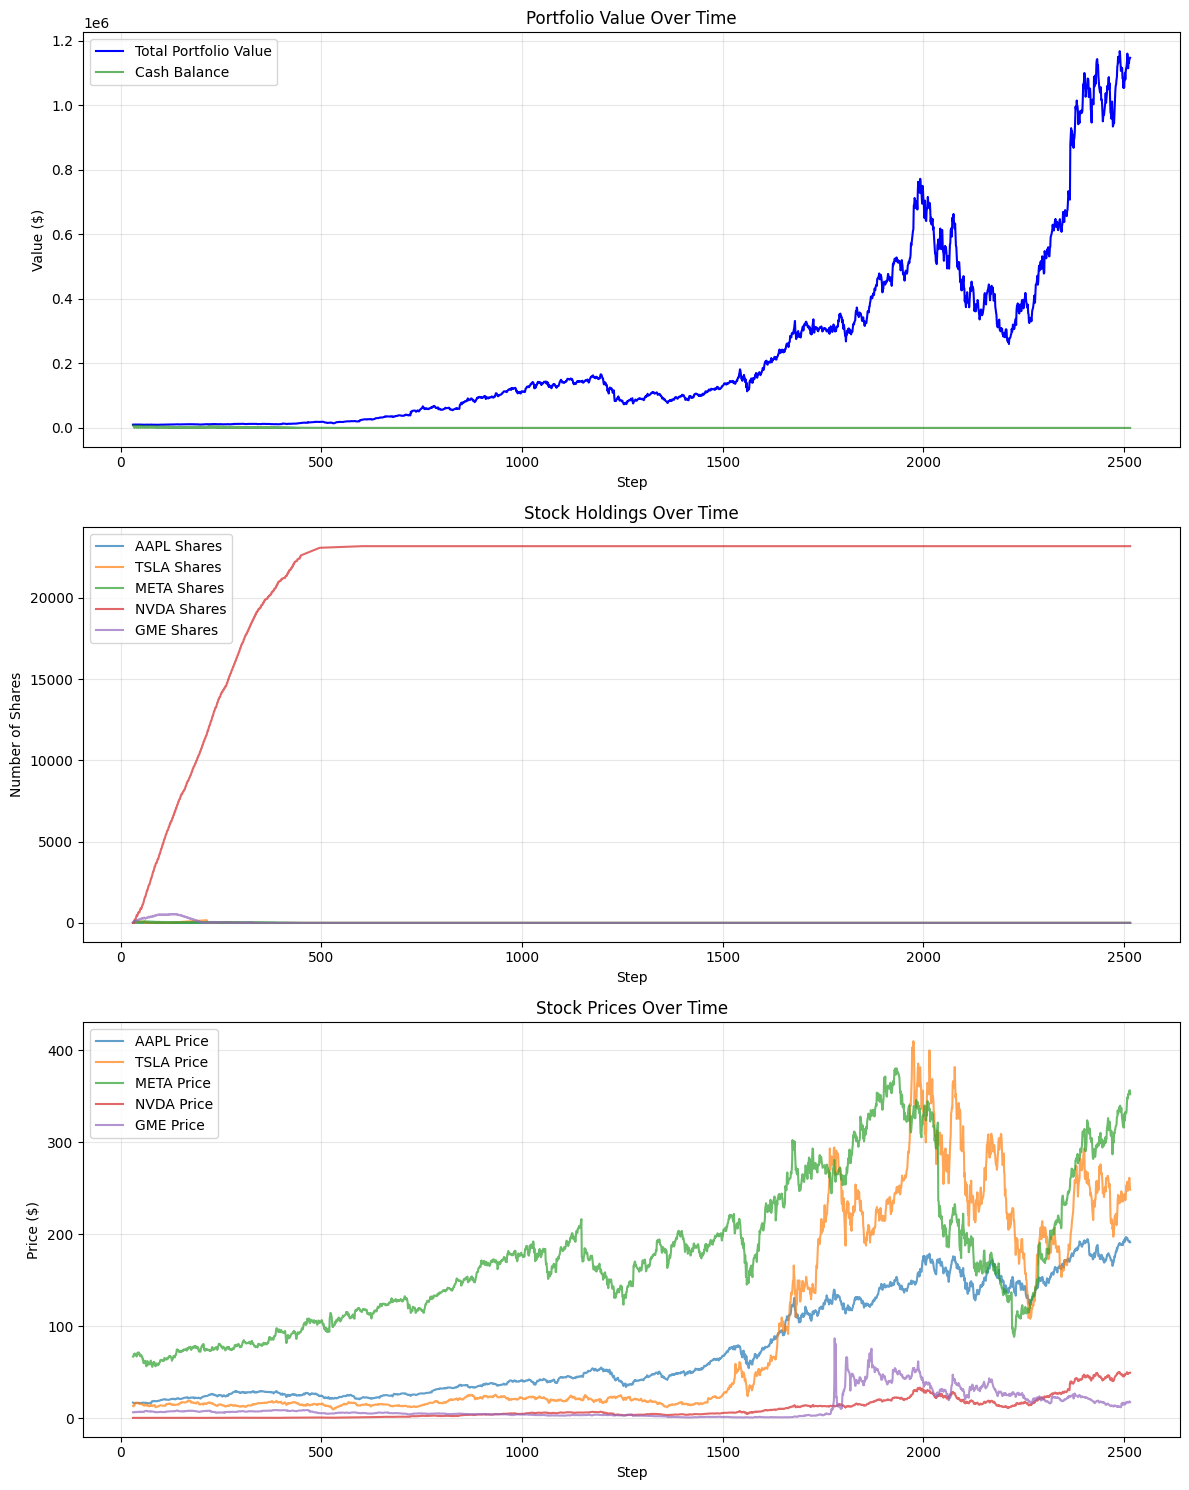

In [12]:
# Visualize the Performance of the Environment
a2c_env.plot_all_metrics()

# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.


### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   


### Future work
Looking at the limitations and/or the toughest parts of the problem and/or the situations where the algorithm(s) did the worst... is there something you'd like to try to make these better.

### Ethics & Privacy

If your project has obvious potential concerns with ethics or data privacy discuss that here.  Almost every ML project put into production can have ethical implications if you use your imagination. Use your imagination.

Even if you can't come up with an obvious ethical concern that should be addressed, you should know that a large number of ML projects that go into producation have unintended consequences and ethical problems once in production. How will your team address these issues?

Consider a tool to help you address the potential issues such as https://deon.drivendata.org

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="lorenznote"></a>1.[^](#lorenz): Lorenz, T. (9 Dec 2021) Birds Aren’t Real, or Are They? Inside a Gen Z Conspiracy Theory. *The New York Times*. https://www.nytimes.com/2021/12/09/technology/birds-arent-real-gen-z-misinformation.html<br> 
<a name="admonishnote"></a>2.[^](#admonish): Also refs should be important to the background, not some randomly chosen vaguely related stuff. Include a web link if possible in refs as above.<br>
<a name="sotanote"></a>3.[^](#sota): Perhaps the current state of the art solution such as you see on [Papers with code](https://paperswithcode.com/sota). Or maybe not SOTA, but rather a standard textbook/Kaggle solution to this kind of problem

# References

### 1. Deep Reinforcement Learning for Automated Stock Trading  
OpenFin Engineering, Columbia University. *Deep Reinforcement Learning for Automated Stock Trading: Framework, Design, and Empirical Analysis*. Available at: [https://openfin.engineering.columbia.edu/sites/default/files/content/publications/ensemble.pdf](https://openfin.engineering.columbia.edu/sites/default/files/content/publications/ensemble.pdf).  

### 2. Application of Deep Reinforcement Learning in Stock Trading Strategies and Stock Forecasting  
Shen, Lun, et al. *Application of Deep Reinforcement Learning in Stock Trading Strategies and Stock Forecasting*. ResearchGate, 2019. Available at: [https://www.researchgate.net/publication/338126351_Application_of_deep_reinforcement_learning_in_stock_trading_strategies_and_stock_forecasting](https://www.researchgate.net/publication/338126351_Application_of_deep_reinforcement_learning_in_stock_trading_strategies_and_stock_forecasting).  

### 3. An Application of Deep Reinforcement Learning to Algorithmic Trading  
Deng, Yunlong, et al. *An Application of Deep Reinforcement Learning to Algorithmic Trading*. arXiv, 2020. Available at: [https://arxiv.org/abs/2004.06627](https://arxiv.org/abs/2004.06627).  
